In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

filterwarnings('ignore')

## 1번

<img src='Tree Sketch.jpeg' size=600>

## 2번
다음과 같은 자료, $ X < c, X \geq c $  분할 기준, 왼쪽 오른쪽 마디 구분

In [2]:
X = np.array([1, 3, 3, 4, 5, 5, 6, 6, 7, 8, 9])
Y = np.array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1])

test = np.vstack([X, Y]).T

In [3]:
tmp = pd.DataFrame(data=[X,Y], index=['X', 'Y']).T
tmp['c=5'] = np.where(np.where(tmp['X']<5, 0, 1) - tmp['Y'] == 0, True, None)
tmp['c=7'] = np.where(np.where(tmp['X']<7, 0, 1) - tmp['Y'] == 0, True, None)
tmp

,X,Y,c=5,c=7
0,1,0,True,True
1,3,0,True,True
2,3,1,None,None
3,4,0,True,True
4,5,0,None,True
5,5,1,True,None
6,6,0,None,True
7,6,1,True,None
8,7,1,True,True
9,8,1,True,True


In [4]:
'''부모마디의 지니 불순도'''
gini_imp = 1 - (tmp[tmp['Y'] == 0]['Y'].count()/len(tmp))**2\
             - (tmp[tmp['Y'] == 1]['Y'].count()/len(tmp))**2
gini_imp

0.4958677685950414

In [5]:
'''c=5, gini'''
gini_1 = 1 - (tmp['c=5'].iloc[:4].count()/len(tmp.iloc[:4]))**2\
           - (tmp['c=5'].iloc[:4].isnull().sum()/len(tmp.iloc[:4]))**2
gini_2 = 1 - (tmp['c=5'].iloc[4:].count()/len(tmp.iloc[4:]))**2\
           - (tmp['c=5'].iloc[4:].isnull().sum()/len(tmp.iloc[4:]))**2

gini_1, gini_2

gini_impurity = (len(tmp['c=5'].iloc[:4])/len(tmp)) * gini_1 + (len(tmp['c=5'].iloc[4:])/len(tmp)) * gini_2
print(f'Gini Impurity when c=5 : {np.round(gini_impurity,4)}')
print(f'Gini Impurity Improvement : {np.round(gini_imp - gini_impurity, 4)}')


Gini Impurity when c=5 : 0.3961
Gini Impurity Improvement : 0.0998


In [6]:
'''c=7, gini'''
gini_3 = 1 - (tmp['c=7'].iloc[:8].count()/len(tmp.iloc[:8]))**2\
           - (tmp['c=7'].iloc[:8].isnull().sum()/len(tmp.iloc[:8]))**2
gini_4 = 1 - (tmp['c=7'].iloc[8:].count()/len(tmp.iloc[8:]))**2\
           - (tmp['c=7'].iloc[8:].isnull().sum()/len(tmp.iloc[8:]))**2
gini_3, gini_4

gini_impurity_2 = (len(tmp['c=7'].iloc[:8])/len(tmp)) * gini_3 + (len(tmp['c=7'].iloc[8:])/len(tmp)) * gini_4
print(f'Gini Impurity when c=7 : {np.round(gini_impurity_2,4)}')
print(f'Gini Impurity Improvement : {np.round(gini_imp - gini_impurity_2, 4)}')

Gini Impurity when c=7 : 0.3409
Gini Impurity Improvement : 0.155


따라서 c가 7일 때, 지니 불순도가 더 개선된다.

## 3번

Churn_Modelling.csv

In [7]:
raw_df = pd.read_csv('./Data/Churn_Modelling.csv', index_col=0)

In [8]:
X = raw_df[['Age', 'Balance', 'CreditScore', 'EstimatedSalary',\
            'NumOfProducts', 'Tenure', 'Gender', 'HasCrCard', 'IsActiveMember']]
Y = raw_df['Exited']
X['Gender'] = np.where(X['Gender'] == 'Male', 0, 1).copy()

In [9]:
Y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### 3-(1) 분리

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.7, random_state=100, shuffle=True)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((7000, 9), (3000, 9), (7000,), (3000,))

### 3-(2) Adaboost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),\
                         n_estimators=50, random_state=100,
                         algorithm='SAMME.R')
ada.fit(X_train, y_train)
init_reg = accuracy_score(y_val, ada.predict(X_val))
acc = [accuracy_score(y_val, y_valpred) for y_valpred in ada.staged_predict(X_val)]
bst_n_estimators = np.argmax(acc)

print(bst_n_estimators, init_reg)

20 0.8493333333333334


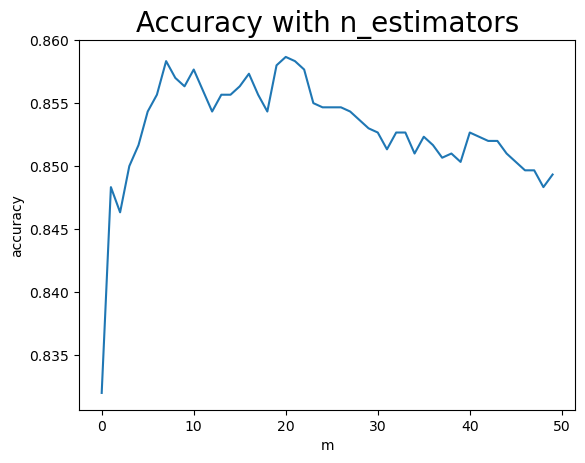

In [12]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.xlabel('m')
plt.ylabel('accuracy')
plt.title('Accuracy with n_estimators', size=20)
plt.show()

In [13]:
ada_best = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),\
                         n_estimators=bst_n_estimators, random_state=2,
                         algorithm='SAMME.R')
ada_best.fit(X_train, y_train)
accuracy_score(y_val, ada_best.predict(X_val))

0.858

### 3-(3) Feature Importance

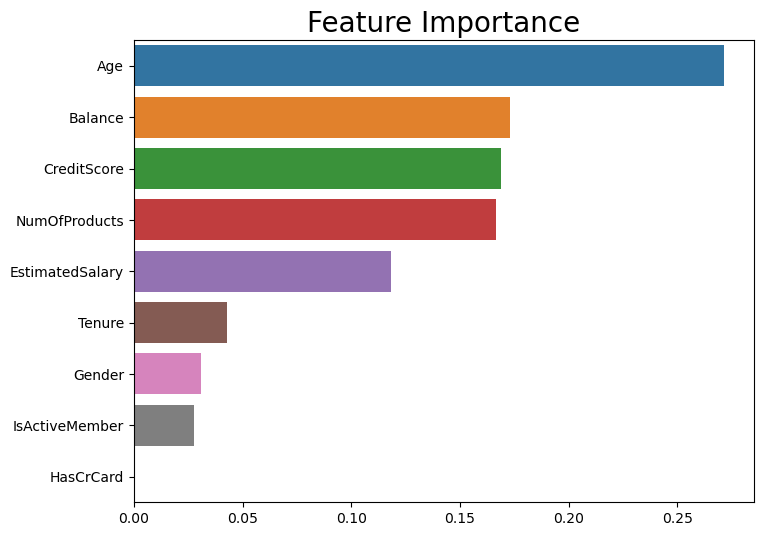

In [14]:
import seaborn as sns

imp_values = pd.Series(ada_best.feature_importances_, index=X_train.columns)
imp_values = imp_values.sort_values(ascending=False)
plt.figure( figsize=(8,6) )
plt.title('Feature Importance', size=20)
sns.barplot(x=imp_values, y=imp_values.index)
plt.show()

중요한 변수는, 순서대로, 'AGE', 'Balance', 'CreditScore' 이다

## 4번

> 답) 1번 2번

배깅은 일부러 왜곡된 데이터를 만들고, (부트스트랩) 노이즈가 다른 분포를 가지는 학습기들을 만들어 결합함으로써 변동으로 인한 영향을 줄일 수 있다.

## 5번

### PCA

$$\text{COV}_{matrix}=P\Sigma P^{T}$$

P는 고유벡터(고유값 순으로 정렬된 것), $\Sigma$ 는 diagonal한 고유값 행렬

In [15]:
cov = np.array([[4, 2, 0 ],
                [2, 9, 6 ],
                [0, 6, 16]])

eig_value, eig_vector = np.linalg.eig(cov)
'''Eigenvalues and vectors sorting'''
idx = eig_value.argsort()[::-1]
eig_value = eig_value[idx]
eig_vector = eig_vector[:,idx]

In [16]:
'''주성분'''
print(np.round(eig_vector[:,0],3),
      np.round(eig_vector[:,1],3),
      np.round(eig_vector[:,2],3), sep='\n')

[0.065 0.504 0.861]
[-0.535 -0.711  0.456]
[-0.842  0.491 -0.224]


PCA를 통해 구한 주성분 <br>

$주성분_1 = + 0.065 x_1 + 0.504 x_2 + 0.861 x_3$ <br>
$주성분_2 = -0.535 x_1 - 0.711 x_2 + 0.456 x_3$ <br>
$주성분_3 = -0.842 x_1 + 0.491 x_2 - 0.224 x_3$ <br>

In [17]:
'''Explained Variance Ratio'''
explained_variance = []

for i in range(len(eig_value)):
    explained_variance.append(eig_value[i] / np.sum(eig_value))

print(np.round(explained_variance,3))

[0.673 0.229 0.098]


주성분 별 Explained Ratio

$주성분_1 = 0.673 = 67.3\%$ <br>
$주성분_2 = 0.229 = 22.9\%$ <br>
$주성분_3 = 0.098 = 9.80\%$ <br>


## 6번
상관행렬을 이용한 주성분 분석 : 표준화 변수를 이용한 공분산 행렬을 주성분 분석에 활용

### 6-(1): 첫 두개의 주성분 산출 식

In [18]:
df = pd.read_csv('Data/PCAdata.csv')

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_scaled = StandardScaler().fit_transform(df)
pca = PCA(n_components=4)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)
pca.components_[:2,]

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864]])

$주성분_1 = 0.536 x_1 + 0.583 x_2 + 0.278 x_3 + 0.543 x_4$ <br>
$주성분_2 = 0.418 x_1 + 0.188 x_2 - 0.873 x_3 - 0.167 x_4$

### 6-(2)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_scaled = StandardScaler().fit_transform(df)
pca = PCA(n_components=4)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)
np.round(pca.explained_variance_ratio_[0:2].sum(), 4) * 100,\
         pca.explained_variance_ratio_[0:2]

(86.75, array([0.62006039, 0.24744129]))

첫 두개의 주성분은, 특성변수의 전체 변동 중 약 86.75%를 설명하고 있다. (62% & 24.74%)

In [21]:
pd.DataFrame(df_pca, index=df.index, columns=[f'pca{num+1}' for num in range(df.shape[1])]).head()

,pca1,pca2,pca3,pca4
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


### 6-(3) 첫 두개의 주성분 점수를 산점도를 이용해 시각화

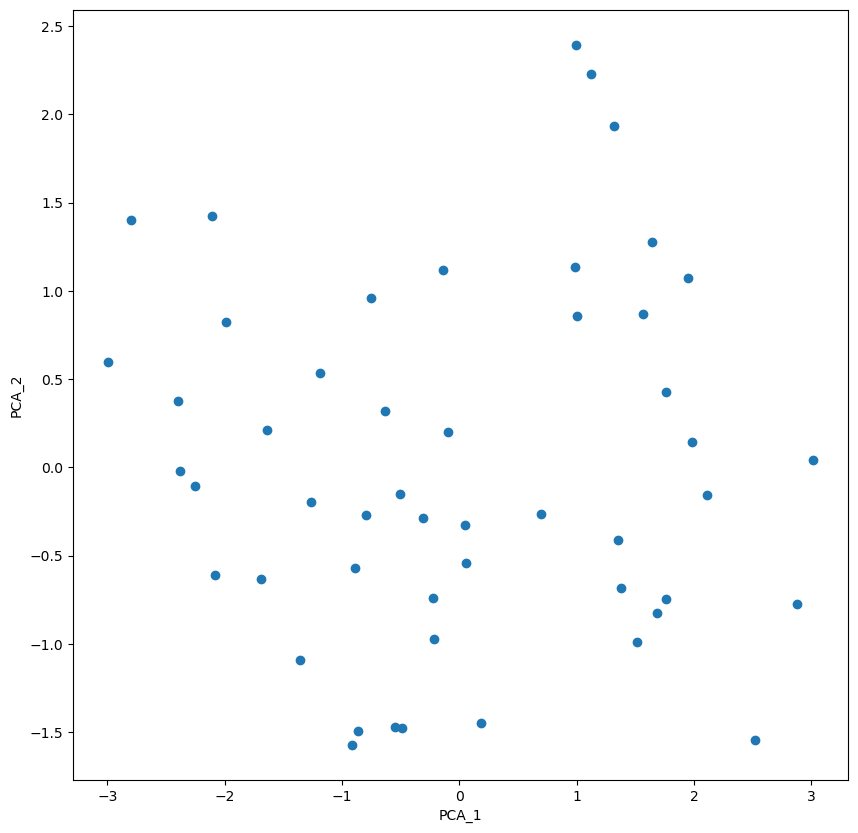

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(df_pca[:,0], df_pca[:,1])
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

### 6-(4)

<AxesSubplot:title={'center':'2st PC Loadings'}>

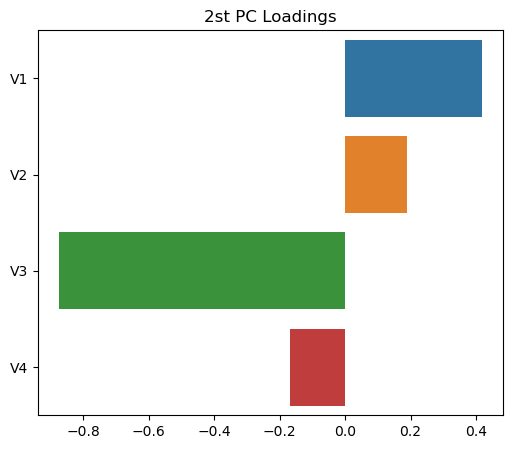

In [23]:
plt.figure(figsize=(6,5))
plt.title('2st PC Loadings')
sns.barplot(x=pca.components_[1], y=df.columns)

두번째 주성분은 첫번째 주성분 다음으로 데이터의 변동이 큰 주성분이며, V3의 변수의 변동을 음의 방향으로 크게 반영하는 주성분이다. 첫번째 주성분과 비교했을 때, 각 특성변수 중, V3의 영향이 두드러지며, 음의 방향으로 이 V3 특성을 반영하고 있다.